<a href="https://colab.research.google.com/github/Fkmentor21/Securo-Guard-/blob/main/Training_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
# Load data
data = pd.read_csv("fake_reviews_dataset (1).csv")
texts = data['reviews']  # Adjust the column name
labels = data['class']  # Assuming 0 = fake, 1 = real

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.4, random_state=10)

In [ ]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize the text
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)

# Convert labels to tensors
train_labels = torch.tensor(train_labels.values)
val_labels = torch.tensor(val_labels.values)

# Convert encodings to PyTorch dataset format
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset = ReviewDataset(val_encodings, val_labels)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,  # Increased batch size
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",
    fp16=True,              # Enabled FP16 training
    gradient_accumulation_steps=2,  # Gradient accumulation
    max_grad_norm=1.0          # Gradient clipping
)
# training_args = TrainingArguments(
#     output_dir='./results',          # Output directory
#     num_train_epochs=3,              # Number of training epochs
#     per_device_train_batch_size=16,  # Batch size for training
#     per_device_eval_batch_size=64,   # Batch size for evaluation
#     warmup_steps=500,                # Number of warmup steps for learning rate scheduler
#     weight_decay=0.01,               # Strength of weight decay
#     logging_dir='./logs',            # Directory for storing logs
#     logging_steps=10,
#     report_to = "none"
# )



In [ ]:
trainer = Trainer(
    model=model,                         # The model to train
    args=training_args,                  # The training arguments
    train_dataset=train_dataset,         # The training dataset
    eval_dataset=val_dataset             # The validation dataset
)

In [ ]:
# Function to save the model and tokenizer
def save_model(output_dir):
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model and tokenizer saved to {output_dir}")

# Train the model
trainer.train()


Step,Training Loss
10,1.440700
20,1.427000
30,1.386300
40,1.362200
50,1.315900
60,1.244000
70,1.140200
80,1.065700
90,0.963100
100,0.878500


TrainOutput(global_step=1257, training_loss=0.2766599106641639, metrics={'train_runtime': 1796.0375, 'train_samples_per_second': 44.845, 'train_steps_per_second': 0.7, 'total_flos': 2.114991907405824e+16, 'train_loss': 0.2766599106641639, 'epoch': 2.9940405244338497})

In [ ]:
# Evaluate the model
trainer.evaluate()

{'eval_loss': 0.1787128448486328,
 'eval_runtime': 130.582,
 'eval_samples_per_second': 137.071,
 'eval_steps_per_second': 2.144,
 'epoch': 2.9940405244338497}

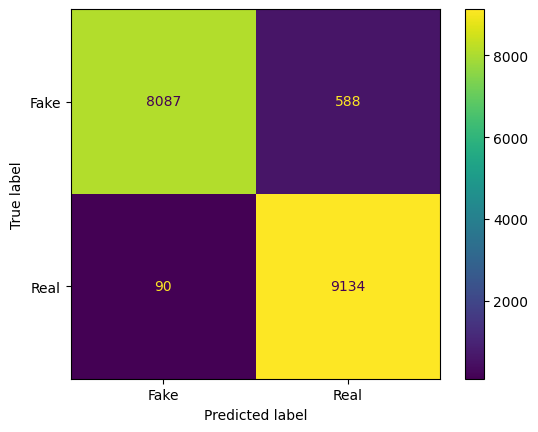

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the trained model and tokenizer
#model_path = "./my_custom_model"  # Replace with your model path
#model = BertForSequenceClassification.from_pretrained(model_path)
#tokenizer = BertTokenizer.from_pretrained(model_path)

# Assuming val_texts and val_labels are already available from your previous code
test_texts = val_texts
test_labels = val_labels


# Tokenize the test reviews
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, return_tensors="pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get the device
test_encodings = test_encodings.to(device) # move encodings to same device as model
model.to(device)

# Get predictions from the model in batches
batch_size = 32  # Adjust as needed
predicted_classes = []
for i in range(0, len(test_encodings['input_ids']), batch_size):
    batch_encodings = {k: v[i:i + batch_size].to(device) for k, v in test_encodings.items()}
    with torch.no_grad():
        outputs = model(**batch_encodings)
        logits = outputs.logits
    predicted_classes.extend(np.argmax(logits.cpu().numpy(), axis=1))  # Move logits to CPU before argmax


# Generate the confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

test_labels = np.array(test_labels)
accuracy = accuracy_score(test_labels, predicted_classes)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.96


In [ ]:
# Save the model after training
save_model("./my_custom_model")

Model and tokenizer saved to ./my_custom_model


---
**Testing**



In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import numpy as np

# Load the trained model and tokenizer
model = BertForSequenceClassification.from_pretrained("./my_custom_model")  # Replace with your model path
tokenizer = BertTokenizer.from_pretrained("./my_custom_model")

# Reviews to test (without labels)
unlabeled_reviews = [
 "I have long wanted to eat Teppanyaki style food and been thinking of going to Benihana for a longest time. But after reading reviews on Yelp for the one in Sunnyvale, CA, I was quite apprehensive.I had also heard good things about Benihana in Pittsburgh from my brother in law and so decided to go there whenever I goto Pittsburgh.So, finally, we went there after New Years and had a blast. We had to wait at the bar even after making reservation, but thats OK. At the table we were not rushed at all. The food was tasty and the chef was funny and interesting. Not to mention very entertaining and friendly bartender  - MARTY.Overall, it was one of the best restaurant experiences we ever had.",

"Have ordered from Jim about 5 or 6 times and each order was flawless. They do everything right - efficient in taking an order, putting together a beautiful arrangement, and getting it delivered when it is needed. Our most recent order was a few days ago for a funeral viewing and it was very nice as always.  Great people, quality work, and you don't need to wonder if they are going to get it right. They are our go-to florist.",

"OMG... I totally love this place! I am happy now that I do not have to go all the way to Chinatown for boba, but sad that they don't have more than one location.I order mostly from their milk tea menu, but sometimes get the slushies with milk too---it is not on the menu, but you can definitely order it. The fishballs are soooo good. I ordered them not spicy, but they still have somewhat of a tang to them.The staff is friendly and their service is speedy, but it depends on how many people are there. I have never found this place empty!You gotta go here!Note: Don't forget to get a stamp card! 10 stamps and you a get free boba! :)",

"Theresa and Joanne at Forever Young Aesthetics are a dream team! Joanne was amazingly kind, accommodating, and responsive to all of my complicated appointment booking needs (I reside in Flagstaff and wished to make the trip to Surprise just for Theresa's permanent makeup artistry) and Theresa simply has to be the very best in the business! Not only was the procedure for permanent eyeliner and brows discussed thoroughly with me prior to choosing a single color, I was made to feel completely at ease and fully confident in my choice to proceed. As one would expect from a talent like Theresa, the results of my permanent makeup are absolutely perfect and, simply put, stunning. In fact, I was making my way through a local grocery store less than 30 minutes post procedure and was stopped twice in the aisles for compliments on the color of my eyes. I my book, that's a five star review for Forever Young Aesthetics right there!A million thanks are owed to Theresa and Joanne for their phenomenal customer service and the fantastic results! When you can enter a business a customer and leave a friend, you know you've found something truly special.",

"Probably the only restaurant that the service was so terrible that I have left before getting my food. Me and my boyfriend went here with a groupon, that we had purchased specifically for Fujo. They refused to take it, and the manager told us, ""you have two choices, ask for a refund from groupon or just eat here without it."" If we had been rude then I wouldn't be able to blame him, but we had politely and calmly spoke to them and asked about it. We walked out and went to Emzy for sushi instead and it had great service and excellent food.",

"This bar is cramped, overpriced, and the service is unbelievably slow. Happy Hour runs 4-6, so you'll show up at 5, have no place to sit or stand, and will only be able to get *maybe* 2 drinks during happy hours You'll then be told that the upstairs (which is actually not bad) will be opening at 5, even though you're asking at 5:20 (this has seriously happened all three times I've been there).Seriously, avoid this place. When one of your co-workers suggests a work happy hour, direct them anywhere else."


]

# Tokenize the reviews
inputs = tokenizer(unlabeled_reviews, truncation=True, padding=True, return_tensors="pt")

# Get predictions from the model
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Convert logits to probabilities and predicted classes
probabilities = torch.nn.functional.softmax(logits, dim=-1)
predicted_classes = np.argmax(probabilities.numpy(), axis=1)  # 0 = fake, 1 = real

# Print the results
for review, prediction, prob in zip(unlabeled_reviews, predicted_classes, probabilities):
    print(f"Review: {review}")
    print(f"Predicted Class: {'Real' if prediction == 1 else 'Fake'}")
    print(f"Confidence: Real = {prob[1]:.2f}, Fake = {prob[0]:.2f}")
    print("-" * 40)

Review: I have long wanted to eat Teppanyaki style food and been thinking of going to Benihana for a longest time. But after reading reviews on Yelp for the one in Sunnyvale, CA, I was quite apprehensive.I had also heard good things about Benihana in Pittsburgh from my brother in law and so decided to go there whenever I goto Pittsburgh.So, finally, we went there after New Years and had a blast. We had to wait at the bar even after making reservation, but thats OK. At the table we were not rushed at all. The food was tasty and the chef was funny and interesting. Not to mention very entertaining and friendly bartender  - MARTY.Overall, it was one of the best restaurant experiences we ever had.
Predicted Class: Real
Confidence: Real = 1.00, Fake = 0.00
----------------------------------------
Review: Have ordered from Jim about 5 or 6 times and each order was flawless. They do everything right - efficient in taking an order, putting together a beautiful arrangement, and getting it delive

In [ ]:
from google.colab import files
import shutil

shutil.make_archive('download_this', 'zip', './my_custom_model')
# files.download('my_custom_model.zip')

'/content/download_this.zip'